In [1]:
# 1. 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# 2. ETT 데이터 경로 및 파일 설정
ett_path = '/content/'  # 코랩의 경우 경로 설정 필요
ett_files = ['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv']

In [7]:
# 3. 데이터 로드 함수 정의
def load_ett_file(file_name):
    file_path = ett_path + file_name
    df = pd.read_csv(file_path)
    print(f"Loaded {file_name} with shape: {df.shape}")
    return df

# 4. 모든 데이터 로드
datasets = {file: load_ett_file(file) for file in ett_files}

# 5. ETTDataset 클래스 정의
class ETTDataset(Dataset):
    def __init__(self, df, scaler=None, seq_len=336, pred_len=48, scale=True):
        """
        ETTDataset 초기화

        Parameters:
        - df (pd.DataFrame): 입력 데이터프레임
        - scaler (StandardScaler, optional): 미리 학습된 스케일러. None인 경우 새로 학습
        - seq_len (int): 입력 시퀀스 길이
        - pred_len (int): 예측 길이
        - scale (bool): 스케일링 여부
        """
        super().__init__()
        x_y = df.iloc[:, 1:].to_numpy(dtype=np.float32)  # 첫 번째 열 제외 (타임스탬프)

        if scale:
            if scaler is None:
                self.scaler = StandardScaler()
                x_y = self.scaler.fit_transform(x_y)
            else:
                self.scaler = scaler
                x_y = self.scaler.transform(x_y)
        else:
            self.scaler = None

        self.data_x = x_y
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __getitem__(self, index):
        """
        특정 인덱스의 데이터 샘플 반환

        Parameters:
        - index (int): 데이터 인덱스

        Returns:
        - seq_x (torch.Tensor): 입력 시퀀스
        - seq_y (torch.Tensor): 타겟 값
        """
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end
        r_end = r_begin + self.pred_len
        seq_x = self.data_x[s_begin:s_end]  # 입력 시퀀스
        seq_y = self.data_x[r_begin:r_end, -1]  # 타겟 변수 (마지막 피처)
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

    def __len__(self):
        """
        데이터셋의 전체 길이 반환
        """
        return len(self.data_x) - self.seq_len - self.pred_len + 1

# 6. ETTm2 데이터셋 로드 및 분할
df = datasets['ETTm2.csv']

Loaded ETTh1.csv with shape: (17420, 8)
Loaded ETTh2.csv with shape: (17420, 8)
Loaded ETTm1.csv with shape: (63491, 8)
Loaded ETTm2.csv with shape: (60938, 8)


In [8]:
# 시계열 데이터이므로 시간 순서를 유지하여 분할
total_length = len(df)
train_size = int(total_length * 0.7)
val_size = int(total_length * 0.15)
test_size = total_length - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")


Train set shape: (42656, 8)
Validation set shape: (9140, 8)
Test set shape: (9142, 8)


In [9]:
# 7. 데이터셋 생성
train_dataset = ETTDataset(train_df, seq_len=336, pred_len=48, scale=True)
val_dataset = ETTDataset(val_df, seq_len=336, pred_len=48, scale=True)
test_dataset = ETTDataset(test_df, seq_len=336, pred_len=48, scale=True)

In [10]:
# 8. DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# 9. 모델 정의
class PatchTST(nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, d_model=128):
        super(PatchTST, self).__init__()
        self.flatten = nn.Flatten()  # 데이터를 일렬로 펼침
        self.backbone = nn.Sequential(
            nn.Linear(context_window * c_in, d_model),  # (seq_len * num_features → d_model)
            nn.ReLU(),
            nn.Linear(d_model, target_window)  # (d_model → target_window)
        )

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, seq_len * num_features)
        return self.backbone(x)  # (batch_size, target_window)

class LSTM3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout1):
        super(LSTM3, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hs=None):
        out, hs = self.lstm(x, hs)
        out = self.fc(out[:, -1, :])  # 마지막 시간 단계의 출력
        return out, hs

class CombinedModel(nn.Module):
    def __init__(self, patchtst_model, lstm_model, patchtst_output_size, lstm_input_size):
        super(CombinedModel, self).__init__()
        self.patchtst = patchtst_model
        self.feature_projection = nn.Linear(patchtst_output_size, lstm_input_size)  # 크기 변환
        self.lstm = lstm_model

    def forward(self, x):
        patchtst_output = self.patchtst(x)  # PatchTST 출력
        transformed_features = self.feature_projection(patchtst_output)  # 크기 변환
        transformed_features = transformed_features.unsqueeze(1)  # (batch_size, 1, lstm_input_size)
        lstm_output, _ = self.lstm(transformed_features)  # LSTM에 입력
        return lstm_output

In [3]:
# 10. 평가 함수 정의
def evaluate(model, data_loader, device, criterion=nn.MSELoss()):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.float().to(device), y.float().to(device)
            output = model(x)
            # CombinedModel은 단일 출력만 반환하므로 언팩하지 않습니다.
            loss = criterion(output.squeeze(), y)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [4]:
# 추가적인 평가 지표 함수 (선택 사항)
def evaluate_metrics(model, data_loader, device):
    model.eval()
    mse_loss = 0
    mae_loss = 0
    criterion_mse = nn.MSELoss()
    criterion_mae = nn.L1Loss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.float().to(device), y.float().to(device)
            output, _ = model(x) if isinstance(model, CombinedModel) else (model(x), None)
            mse_loss += criterion_mse(output.squeeze(), y).item()
            mae_loss += criterion_mae(output.squeeze(), y).item()
    avg_mse = mse_loss / len(data_loader)
    avg_mae = mae_loss / len(data_loader)
    return avg_mse, avg_mae

In [5]:
# 11. 훈련 및 검증 함수 정의
def train_and_validate(model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="Model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_loss_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad()
            output = model(x)
            # CombinedModel은 단일 출력만 반환하므로 언팩하지 않습니다.
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.float().to(device), y.float().to(device)
                output = model(x)
                # CombinedModel은 단일 출력만 반환하므로 언팩하지 않습니다.
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"[{model_name}] Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

In [12]:
# 12. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 13. PatchTST 모델 학습
patchtst_model = PatchTST(c_in=7, context_window=336, target_window=48, patch_len=16, stride=8).to(device)
patchtst_train_loss, patchtst_val_loss = train_and_validate(
    patchtst_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="PatchTST"
)

Using device: cpu
[PatchTST] Epoch 1/10, Train Loss: 0.0944, Val Loss: 0.2367
[PatchTST] Epoch 2/10, Train Loss: 0.0617, Val Loss: 0.2157
[PatchTST] Epoch 3/10, Train Loss: 0.0540, Val Loss: 0.2446
[PatchTST] Epoch 4/10, Train Loss: 0.0502, Val Loss: 0.2340
[PatchTST] Epoch 5/10, Train Loss: 0.0463, Val Loss: 0.2233
[PatchTST] Epoch 6/10, Train Loss: 0.0445, Val Loss: 0.2497
[PatchTST] Epoch 7/10, Train Loss: 0.0417, Val Loss: 0.2349
[PatchTST] Epoch 8/10, Train Loss: 0.0401, Val Loss: 0.2553
[PatchTST] Epoch 9/10, Train Loss: 0.0375, Val Loss: 0.2561
[PatchTST] Epoch 10/10, Train Loss: 0.0365, Val Loss: 0.2901


In [13]:
# 14. CombinedModel 학습
lstm_model = LSTM3(input_size=48, hidden_size=64, num_layers=2, output_size=48, dropout1=0.2).to(device)
combined_model = CombinedModel(
    patchtst_model, lstm_model, patchtst_output_size=48, lstm_input_size=48
).to(device)
combined_train_loss, combined_val_loss = train_and_validate(
    combined_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="CombinedModel"
)

[CombinedModel] Epoch 1/10, Train Loss: 0.1426, Val Loss: 0.3297
[CombinedModel] Epoch 2/10, Train Loss: 0.0586, Val Loss: 0.2840
[CombinedModel] Epoch 3/10, Train Loss: 0.0422, Val Loss: 0.3049
[CombinedModel] Epoch 4/10, Train Loss: 0.0345, Val Loss: 0.3038
[CombinedModel] Epoch 5/10, Train Loss: 0.0307, Val Loss: 0.2879
[CombinedModel] Epoch 6/10, Train Loss: 0.0272, Val Loss: 0.2848
[CombinedModel] Epoch 7/10, Train Loss: 0.0261, Val Loss: 0.2950
[CombinedModel] Epoch 8/10, Train Loss: 0.0230, Val Loss: 0.3222
[CombinedModel] Epoch 9/10, Train Loss: 0.0218, Val Loss: 0.3063
[CombinedModel] Epoch 10/10, Train Loss: 0.0208, Val Loss: 0.2995


In [14]:
# 15. 테스트 데이터셋 평가
patchtst_test_loss = evaluate(patchtst_model, test_loader, device, criterion=nn.MSELoss())
print(f"PatchTST Test Loss: {patchtst_test_loss:.4f}")

combined_test_loss = evaluate(combined_model, test_loader, device, criterion=nn.MSELoss())
print(f"CombinedModel Test Loss: {combined_test_loss:.4f}")

PatchTST Test Loss: 58.5627
CombinedModel Test Loss: 0.2814


In [15]:
# 17. 손실 비교 시각화
def plot_loss_comparison(train_losses, val_losses, labels, title="Loss Comparison"):
    plt.figure(figsize=(12, 6))

    # Train Loss
    plt.subplot(1, 2, 1)
    for i, train_loss in enumerate(train_losses):
        plt.plot(train_loss, label=f"{labels[i]} Train Loss")
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()

    # Validation Loss
    plt.subplot(1, 2, 2)
    for i, val_loss in enumerate(val_losses):
        plt.plot(val_loss, label=f"{labels[i]} Validation Loss")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

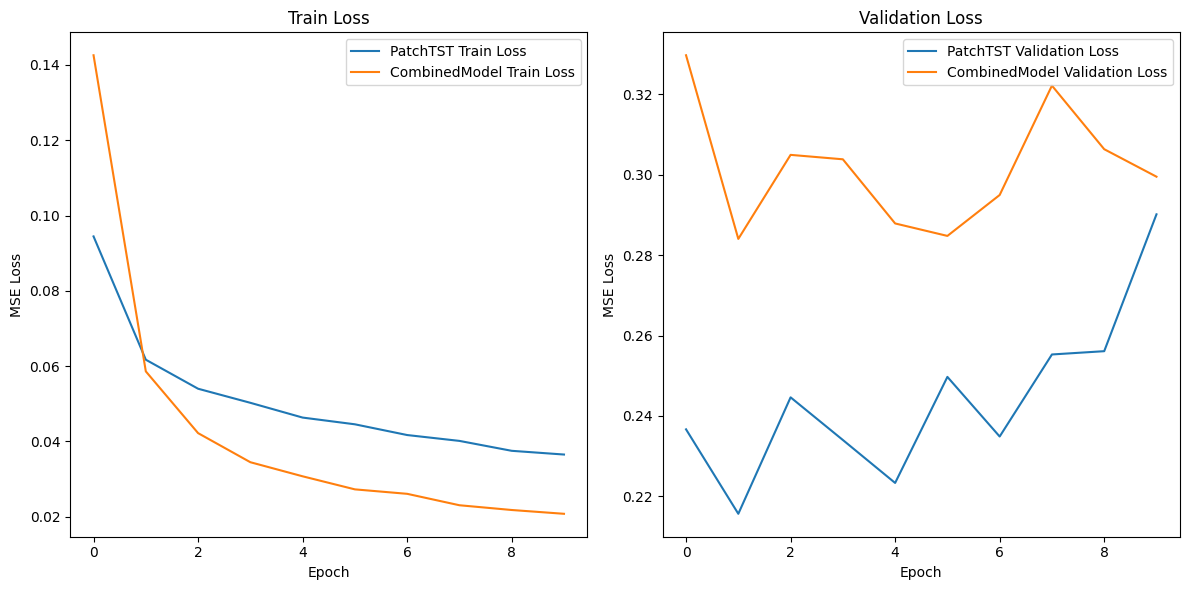

In [16]:
# 손실 비교 플롯
plot_loss_comparison(
    train_losses=[patchtst_train_loss, combined_train_loss],
    val_losses=[patchtst_val_loss, combined_val_loss],
    labels=["PatchTST", "CombinedModel"]
)

In [17]:
# 18. 예측 결과 시각화 (선택 사항)
def plot_predictions(model, data_loader, device, num_batches=1, model_name="Model"):
    """
    실제 값과 모델의 예측 값을 시각화합니다.

    Parameters:
    - model: 예측 모델
    - data_loader: 데이터 로더
    - device: 학습에 사용된 디바이스 (CPU 또는 GPU)
    - num_batches: 시각화할 배치 수
    - model_name: 모델 이름 (플롯 제목에 사용)
    """
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            if i >= num_batches:
                break
            x, y = x.float().to(device), y.float().to(device)
            output = model(x)

            # 예측과 실제 값을 CPU로 이동
            output = output.cpu().numpy()
            y = y.cpu().numpy()

            # 첫 번째 배치의 첫 번째 예측 결과 시각화
            plt.figure(figsize=(12, 6))
            plt.plot(y[0], label='Actual')
            plt.plot(output[0], label=f'{model_name} Predicted')
            plt.title(f'Actual vs {model_name}')
            plt.xlabel('Time Step')
            plt.ylabel('Value')
            plt.legend()
            plt.show()


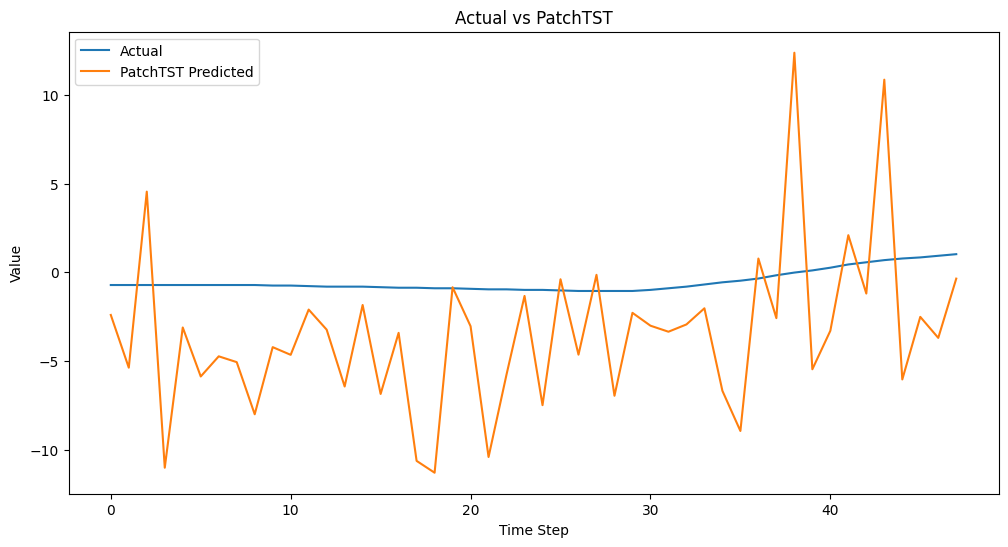

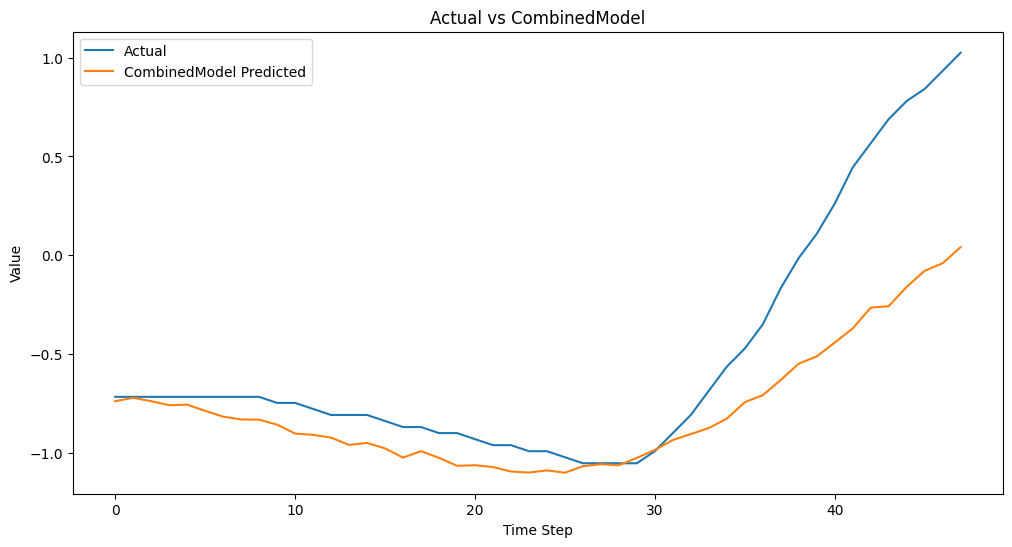

In [18]:
# 예측 결과 시각화
# PatchTST 모델의 예측 결과 시각화
plot_predictions(patchtst_model, test_loader, device, num_batches=1, model_name="PatchTST")

# CombinedModel 모델의 예측 결과 시각화
plot_predictions(combined_model, test_loader, device, num_batches=1, model_name="CombinedModel")


[PatchTST] Epoch 1/10, Train Loss: 0.0955, Val Loss: 0.2644
[PatchTST] Epoch 2/10, Train Loss: 0.0611, Val Loss: 0.2293
[PatchTST] Epoch 3/10, Train Loss: 0.0549, Val Loss: 0.2034
[PatchTST] Epoch 4/10, Train Loss: 0.0506, Val Loss: 0.2250
[PatchTST] Epoch 5/10, Train Loss: 0.0481, Val Loss: 0.2053
[PatchTST] Epoch 6/10, Train Loss: 0.0448, Val Loss: 0.2247
[PatchTST] Epoch 7/10, Train Loss: 0.0424, Val Loss: 0.2389
[PatchTST] Epoch 8/10, Train Loss: 0.0408, Val Loss: 0.2442
[PatchTST] Epoch 9/10, Train Loss: 0.0391, Val Loss: 0.2595
[PatchTST] Epoch 10/10, Train Loss: 0.0371, Val Loss: 0.2635
[CombinedModel] Epoch 1/10, Train Loss: 0.1458, Val Loss: 0.3693
[CombinedModel] Epoch 2/10, Train Loss: 0.0724, Val Loss: 0.3231
[CombinedModel] Epoch 3/10, Train Loss: 0.0473, Val Loss: 0.3214
[CombinedModel] Epoch 4/10, Train Loss: 0.0388, Val Loss: 0.3441
[CombinedModel] Epoch 5/10, Train Loss: 0.0329, Val Loss: 0.3394
[CombinedModel] Epoch 6/10, Train Loss: 0.0290, Val Loss: 0.3362
[Combined

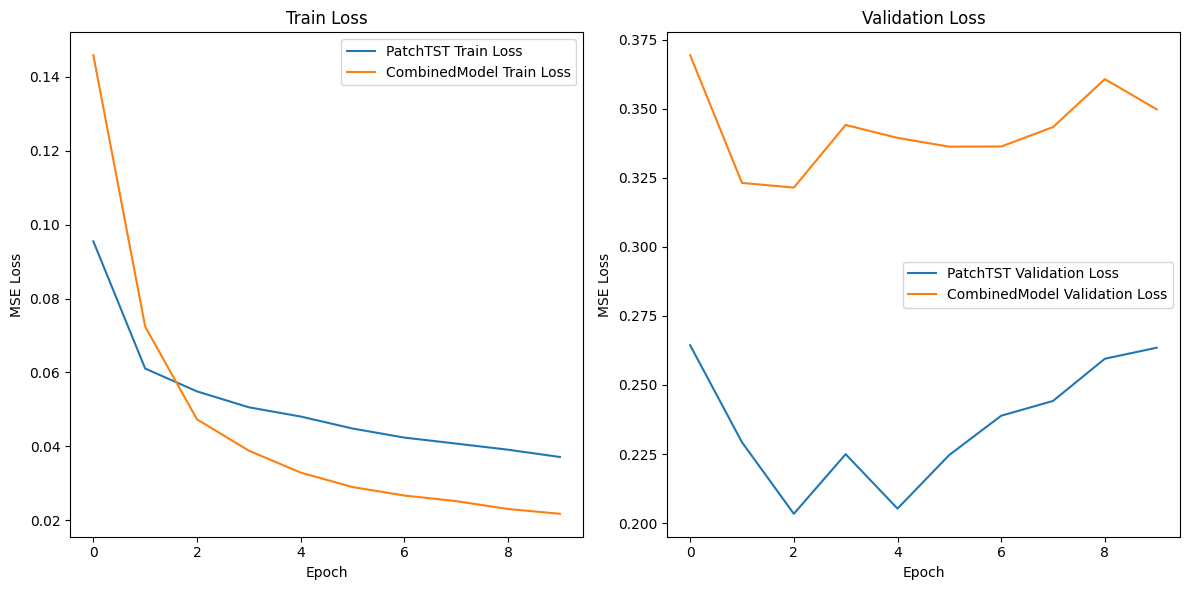

In [20]:
##. 추가 실험
df = datasets['ETTh1.csv']


# # PatchTST 학습
patchtst_model = PatchTST(c_in=7, context_window=336, target_window=48, patch_len=16, stride=8).to(device)
patchtst_train_loss, patchtst_val_loss = train_and_validate(
    patchtst_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="PatchTST"
)

# # CombinedModel 학습
lstm_model = LSTM3(input_size=48, hidden_size=64, num_layers=2, output_size=48, dropout1=0.2).to(device)
combined_model = CombinedModel(
    patchtst_model, lstm_model, patchtst_output_size=48, lstm_input_size=48
).to(device)
combined_train_loss, combined_val_loss = train_and_validate(
    combined_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="CombinedModel"
)

# # 테스트 데이터셋 평가
patchtst_test_loss = evaluate(patchtst_model, test_loader, device, criterion=nn.MSELoss())
print(f"PatchTST Test Loss: {patchtst_test_loss:.4f}")

combined_test_loss = evaluate(combined_model, test_loader, device, criterion=nn.MSELoss())
print(f"CombinedModel Test Loss: {combined_test_loss:.4f}")

# #손실 비교 플롯
plot_loss_comparison(
    train_losses=[patchtst_train_loss, combined_train_loss],
    val_losses=[patchtst_val_loss, combined_val_loss],
    labels=["PatchTST", "CombinedModel"]
)


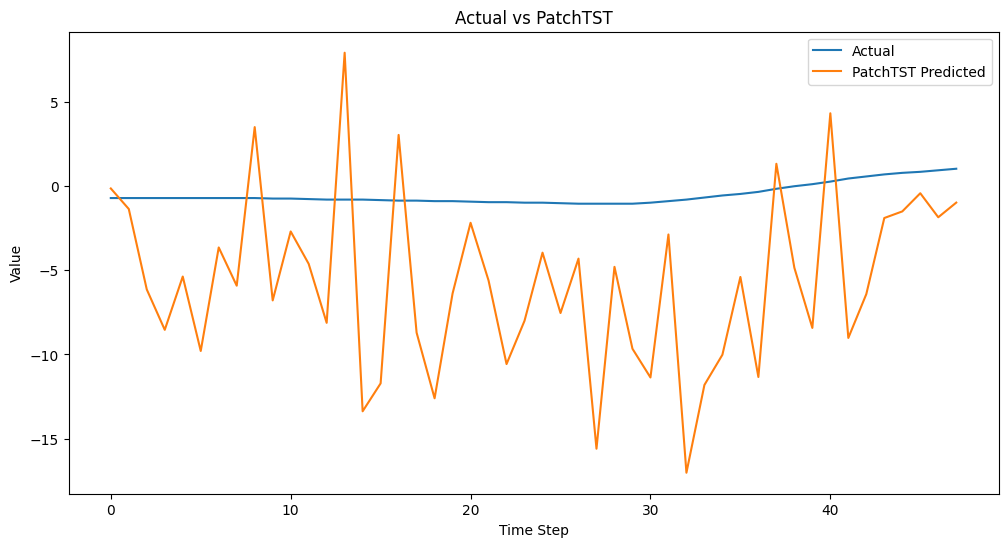

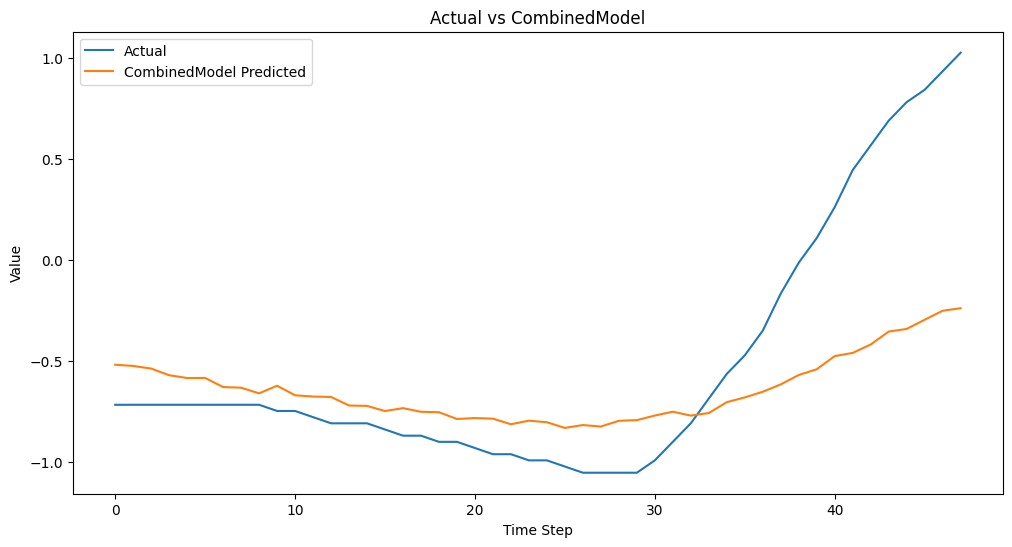

In [21]:
# 예측 결과 시각화
# PatchTST 모델의 예측 결과 시각화
plot_predictions(patchtst_model, test_loader, device, num_batches=1, model_name="PatchTST")

# CombinedModel 모델의 예측 결과 시각화
plot_predictions(combined_model, test_loader, device, num_batches=1, model_name="CombinedModel")

In [22]:
# 추가실험
# 데이터셋 생성
train_dataset = ETTDataset(train_df, seq_len=336, pred_len=96, scale=True)
val_dataset = ETTDataset(val_df, seq_len=336, pred_len=96, scale=True)
test_dataset = ETTDataset(test_df, seq_len=336, pred_len=96, scale=True)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
# 모델 정의
class PatchTST(nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, d_model=128):
        super(PatchTST, self).__init__()
        self.flatten = nn.Flatten()  # 데이터를 일렬로 펼침
        self.backbone = nn.Sequential(
            nn.Linear(context_window * c_in, d_model),  # (seq_len * num_features → d_model)
            nn.ReLU(),
            nn.Linear(d_model, target_window)  # (d_model → target_window)
        )

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, seq_len * num_features)
        return self.backbone(x)  # (batch_size, target_window)

class LSTM3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout1):
        super(LSTM3, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hs=None):
        out, hs = self.lstm(x, hs)
        out = self.fc(out[:, -1, :])  # 마지막 시간 단계의 출력
        return out, hs

class CombinedModel(nn.Module):
    def __init__(self, patchtst_model, lstm_model, patchtst_output_size, lstm_input_size):
        super(CombinedModel, self).__init__()
        self.patchtst = patchtst_model
        self.feature_projection = nn.Linear(patchtst_output_size, lstm_input_size)  # 크기 변환
        self.lstm = lstm_model

    def forward(self, x):
        patchtst_output = self.patchtst(x)  # PatchTST 출력
        transformed_features = self.feature_projection(patchtst_output)  # 크기 변환
        transformed_features = transformed_features.unsqueeze(1)  # (batch_size, 1, lstm_input_size)
        lstm_output, _ = self.lstm(transformed_features)  # LSTM에 입력
        return lstm_output

In [24]:
# 훈련 및 검증 함수 정의
def train_and_validate(model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="Model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_loss_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad()
            output = model(x)
            # CombinedModel은 단일 출력만 반환하므로 언팩하지 않습니다.
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.float().to(device), y.float().to(device)
                output = model(x)
                # CombinedModel은 단일 출력만 반환하므로 언팩하지 않습니다.
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"[{model_name}] Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

[PatchTST] Epoch 1/10, Train Loss: 0.1128, Val Loss: 0.2727
[PatchTST] Epoch 2/10, Train Loss: 0.0803, Val Loss: 0.2615
[PatchTST] Epoch 3/10, Train Loss: 0.0718, Val Loss: 0.2681
[PatchTST] Epoch 4/10, Train Loss: 0.0676, Val Loss: 0.2713
[PatchTST] Epoch 5/10, Train Loss: 0.0628, Val Loss: 0.2781
[PatchTST] Epoch 6/10, Train Loss: 0.0603, Val Loss: 0.3084
[PatchTST] Epoch 7/10, Train Loss: 0.0572, Val Loss: 0.3155
[PatchTST] Epoch 8/10, Train Loss: 0.0545, Val Loss: 0.3304
[PatchTST] Epoch 9/10, Train Loss: 0.0529, Val Loss: 0.3463
[PatchTST] Epoch 10/10, Train Loss: 0.0496, Val Loss: 0.3430
[CombinedModel] Epoch 1/10, Train Loss: 0.1831, Val Loss: 0.5158
[CombinedModel] Epoch 2/10, Train Loss: 0.1341, Val Loss: 0.5147
[CombinedModel] Epoch 3/10, Train Loss: 0.1032, Val Loss: 0.4418
[CombinedModel] Epoch 4/10, Train Loss: 0.0745, Val Loss: 0.4731
[CombinedModel] Epoch 5/10, Train Loss: 0.0635, Val Loss: 0.5432
[CombinedModel] Epoch 6/10, Train Loss: 0.0590, Val Loss: 0.4757
[Combined

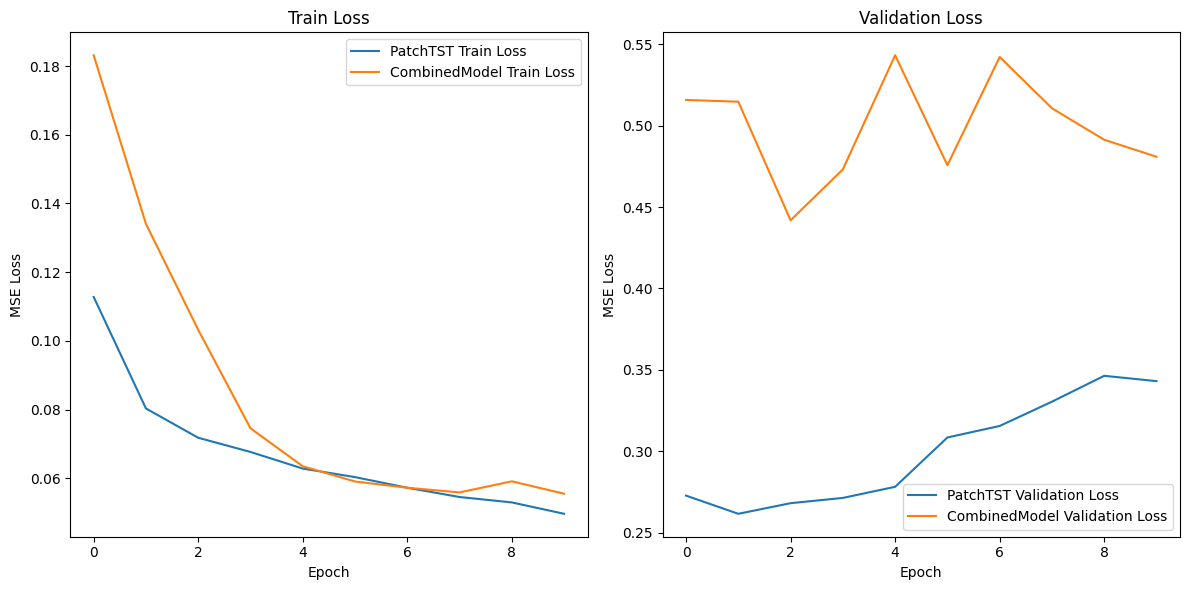

In [25]:
# # PatchTST 학습
patchtst_model = PatchTST(c_in=7, context_window=336, target_window=96, patch_len=16, stride=8).to(device)
patchtst_train_loss, patchtst_val_loss = train_and_validate(
    patchtst_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="PatchTST"
)

# # CombinedModel 학습
lstm_model = LSTM3(input_size=96, hidden_size=64, num_layers=2, output_size=96, dropout1=0.2).to(device)
combined_model = CombinedModel(
    patchtst_model, lstm_model, patchtst_output_size=96, lstm_input_size=96
).to(device)
combined_train_loss, combined_val_loss = train_and_validate(
    combined_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="CombinedModel"
)

# # 테스트 데이터셋 평가
patchtst_test_loss = evaluate(patchtst_model, test_loader, device, criterion=nn.MSELoss())
print(f"PatchTST Test Loss: {patchtst_test_loss:.4f}")

combined_test_loss = evaluate(combined_model, test_loader, device, criterion=nn.MSELoss())
print(f"CombinedModel Test Loss: {combined_test_loss:.4f}")

# #손실 비교 플롯
plot_loss_comparison(
    train_losses=[patchtst_train_loss, combined_train_loss],
    val_losses=[patchtst_val_loss, combined_val_loss],
    labels=["PatchTST", "CombinedModel"]
)

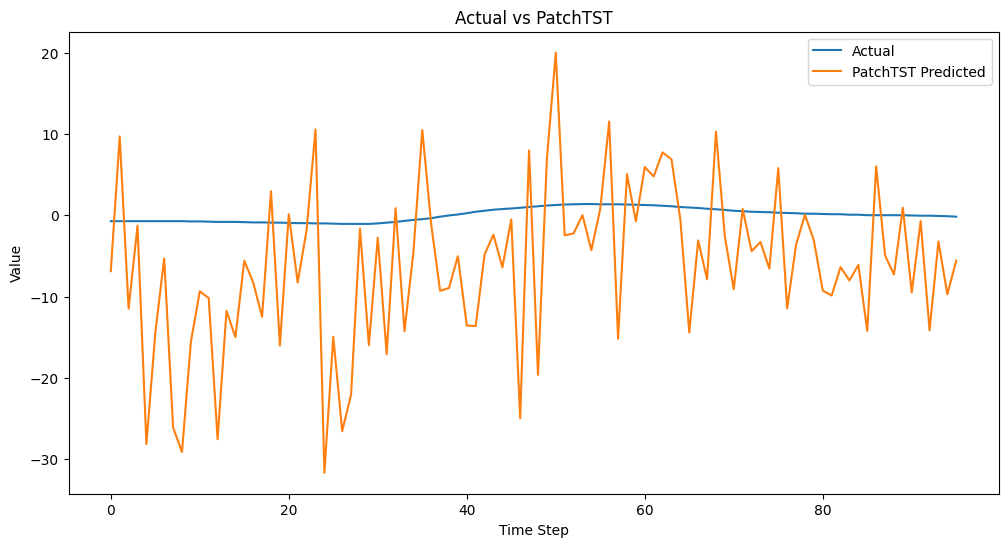

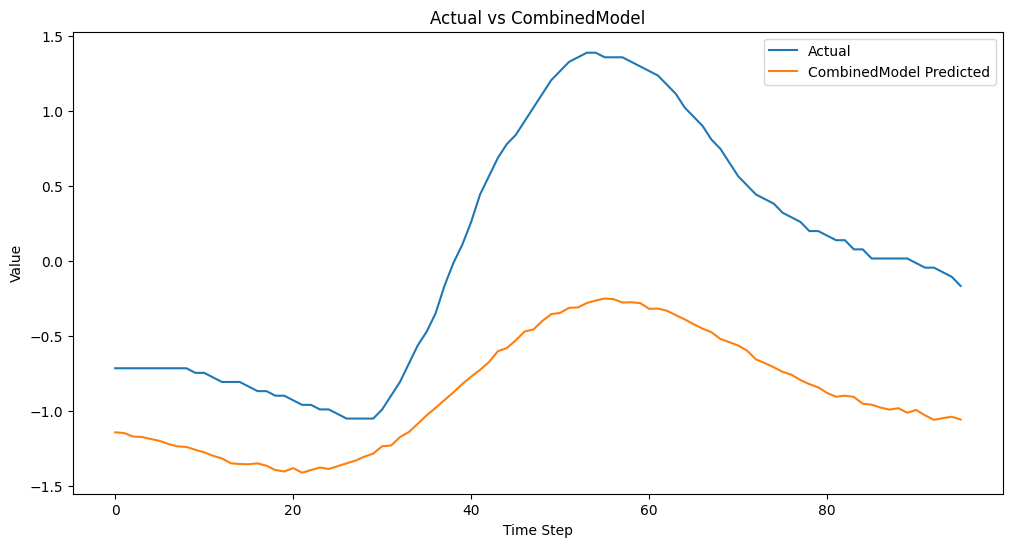

In [26]:
# 예측 결과 시각화
# PatchTST 모델의 예측 결과 시각화
plot_predictions(patchtst_model, test_loader, device, num_batches=1, model_name="PatchTST")

# CombinedModel 모델의 예측 결과 시각화
plot_predictions(combined_model, test_loader, device, num_batches=1, model_name="CombinedModel")

In [27]:
# 추가실험
# 데이터셋 생성
train_dataset = ETTDataset(train_df, seq_len=450, pred_len=120, scale=True)
val_dataset = ETTDataset(val_df, seq_len=450, pred_len=120, scale=True)
test_dataset = ETTDataset(test_df, seq_len=450, pred_len=120, scale=True)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [28]:
# 모델 정의
class PatchTST(nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, d_model=128):
        super(PatchTST, self).__init__()
        self.flatten = nn.Flatten()  # 데이터를 일렬로 펼침
        self.backbone = nn.Sequential(
            nn.Linear(context_window * c_in, d_model),  # (seq_len * num_features → d_model)
            nn.ReLU(),
            nn.Linear(d_model, target_window)  # (d_model → target_window)
        )

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, seq_len * num_features)
        return self.backbone(x)  # (batch_size, target_window)

class LSTM3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout1):
        super(LSTM3, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hs=None):
        out, hs = self.lstm(x, hs)
        out = self.fc(out[:, -1, :])  # 마지막 시간 단계의 출력
        return out, hs

class CombinedModel(nn.Module):
    def __init__(self, patchtst_model, lstm_model, patchtst_output_size, lstm_input_size):
        super(CombinedModel, self).__init__()
        self.patchtst = patchtst_model
        self.feature_projection = nn.Linear(patchtst_output_size, lstm_input_size)  # 크기 변환
        self.lstm = lstm_model

    def forward(self, x):
        patchtst_output = self.patchtst(x)  # PatchTST 출력
        transformed_features = self.feature_projection(patchtst_output)  # 크기 변환
        transformed_features = transformed_features.unsqueeze(1)  # (batch_size, 1, lstm_input_size)
        lstm_output, _ = self.lstm(transformed_features)  # LSTM에 입력
        return lstm_output

In [29]:
# 훈련 및 검증 함수 정의
def train_and_validate(model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="Model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_loss_history = []
    val_loss_history = []

    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.float().to(device), y.float().to(device)
            optimizer.zero_grad()
            output = model(x)
            # CombinedModel은 단일 출력만 반환하므로 언팩하지 않습니다.
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.float().to(device), y.float().to(device)
                output = model(x)
                # CombinedModel은 단일 출력만 반환하므로 언팩하지 않습니다.
                loss = criterion(output.squeeze(), y)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"[{model_name}] Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_history, val_loss_history

[PatchTST] Epoch 1/10, Train Loss: 0.1226, Val Loss: 0.3364
[PatchTST] Epoch 2/10, Train Loss: 0.0836, Val Loss: 0.3264
[PatchTST] Epoch 3/10, Train Loss: 0.0756, Val Loss: 0.3444
[PatchTST] Epoch 4/10, Train Loss: 0.0705, Val Loss: 0.3322
[PatchTST] Epoch 5/10, Train Loss: 0.0642, Val Loss: 0.3662
[PatchTST] Epoch 6/10, Train Loss: 0.0612, Val Loss: 0.3782
[PatchTST] Epoch 7/10, Train Loss: 0.0580, Val Loss: 0.4273
[PatchTST] Epoch 8/10, Train Loss: 0.0534, Val Loss: 0.4578
[PatchTST] Epoch 9/10, Train Loss: 0.0505, Val Loss: 0.4882
[PatchTST] Epoch 10/10, Train Loss: 0.0489, Val Loss: 0.5189
[CombinedModel] Epoch 1/10, Train Loss: 0.1838, Val Loss: 0.5437
[CombinedModel] Epoch 2/10, Train Loss: 0.1220, Val Loss: 0.5325
[CombinedModel] Epoch 3/10, Train Loss: 0.1036, Val Loss: 0.5675
[CombinedModel] Epoch 4/10, Train Loss: 0.0990, Val Loss: 0.5870
[CombinedModel] Epoch 5/10, Train Loss: 0.0867, Val Loss: 0.5271
[CombinedModel] Epoch 6/10, Train Loss: 0.0886, Val Loss: 0.7495
[Combined

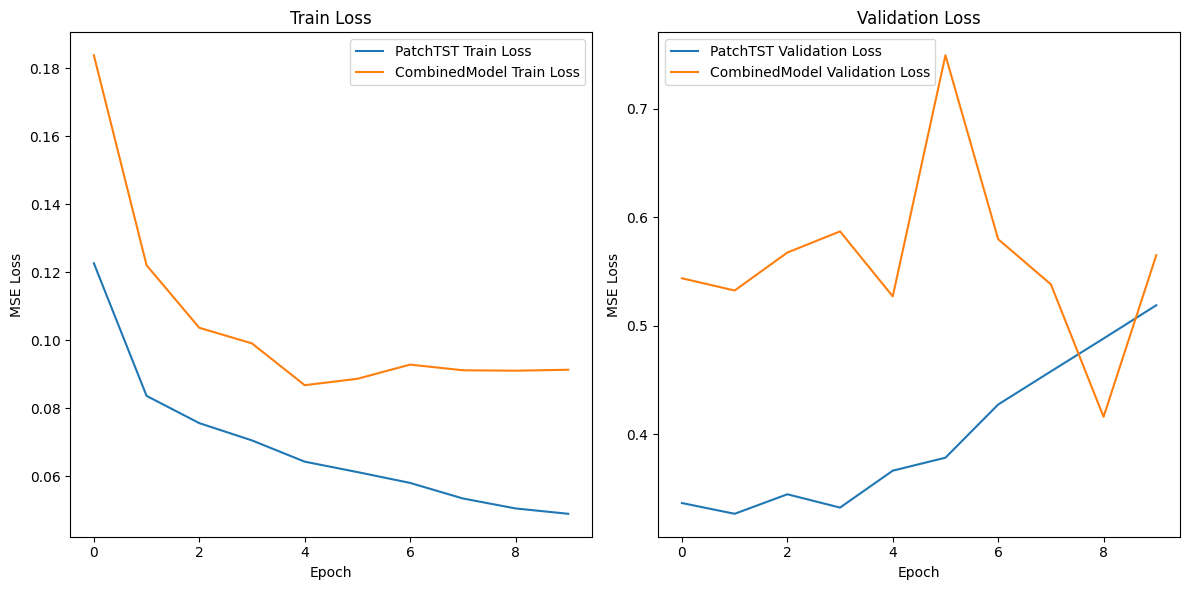

In [30]:
# # PatchTST 학습
patchtst_model = PatchTST(c_in=7, context_window=450, target_window=120, patch_len=16, stride=8).to(device)
patchtst_train_loss, patchtst_val_loss = train_and_validate(
    patchtst_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="PatchTST"
)

# # CombinedModel 학습
lstm_model = LSTM3(input_size=120, hidden_size=64, num_layers=2, output_size=120, dropout1=0.2).to(device)
combined_model = CombinedModel(
    patchtst_model, lstm_model, patchtst_output_size=120, lstm_input_size=120
).to(device)
combined_train_loss, combined_val_loss = train_and_validate(
    combined_model, train_loader, val_loader, n_epochs=10, lr=0.001, model_name="CombinedModel"
)

# # 테스트 데이터셋 평가
patchtst_test_loss = evaluate(patchtst_model, test_loader, device, criterion=nn.MSELoss())
print(f"PatchTST Test Loss: {patchtst_test_loss:.4f}")

combined_test_loss = evaluate(combined_model, test_loader, device, criterion=nn.MSELoss())
print(f"CombinedModel Test Loss: {combined_test_loss:.4f}")

# #손실 비교 플롯
plot_loss_comparison(
    train_losses=[patchtst_train_loss, combined_train_loss],
    val_losses=[patchtst_val_loss, combined_val_loss],
    labels=["PatchTST", "CombinedModel"]
)

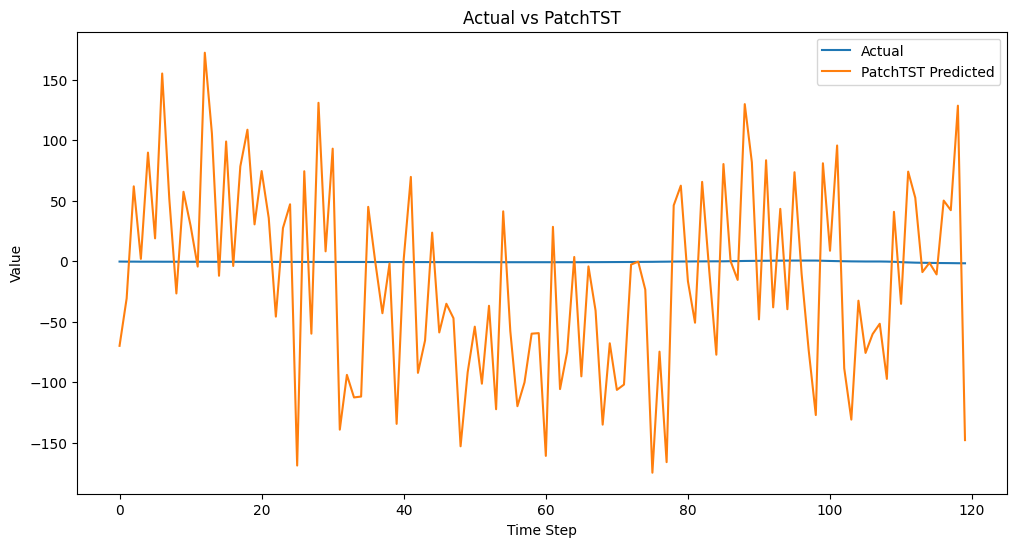

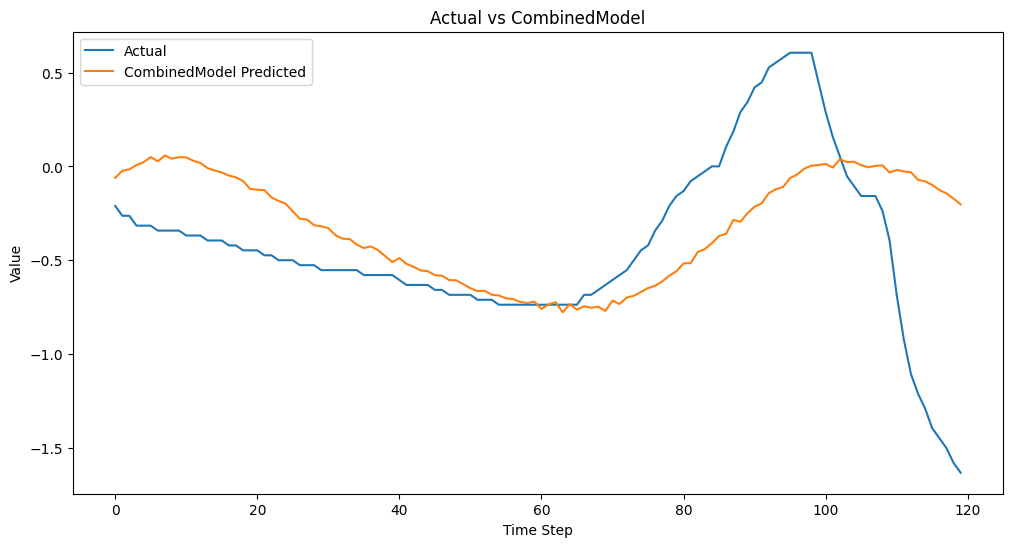

In [30]:
# 예측 결과 시각화
# PatchTST 모델의 예측 결과 시각화
plot_predictions(patchtst_model, test_loader, device, num_batches=1, model_name="PatchTST")

# CombinedModel 모델의 예측 결과 시각화
plot_predictions(combined_model, test_loader, device, num_batches=1, model_name="CombinedModel")